# Supervised Learning with scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sklearn
from sklearn import datasets

## Classification

### KNN (binary)

#### 讀資料集

In [2]:
vote_raw = pd.read_csv("data/house-votes-84.csv")

vote = vote_raw.copy()
col_names = ['party', 'infants', 'water', 'budget', 'physician', 'salvador',
       'religious', 'satellite', 'aid', 'missile', 'immigration', 'synfuels',
       'education', 'superfund', 'crime', 'duty_free_exports', 'eaa_rsa']
vote.columns = col_names
vote[vote == "?"] = np.nan # 把 ? 改成 na
vote = vote.dropna()
for i in col_names[1:]:
    vote[i] = vote[i].replace({"y": 1, "n": 0})
vote

,party,infants,water,budget,physician,salvador,religious,satellite,aid,missile,immigration,synfuels,education,superfund,crime,duty_free_exports,eaa_rsa
4,democrat,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1
7,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
18,democrat,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1
22,democrat,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1,1
24,democrat,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,democrat,0,1,1,0,0,1,1,1,1,0,1,0,0,1,1,1
425,democrat,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1
426,republican,0,0,0,1,1,1,1,1,0,1,0,1,1,1,0,1
429,republican,0,0,1,1,1,1,0,0,1,1,0,1,1,1,0,1


In [3]:
vote.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 4 to 430
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   party              232 non-null    object
 1   infants            232 non-null    int64 
 2   water              232 non-null    int64 
 3   budget             232 non-null    int64 
 4   physician          232 non-null    int64 
 5   salvador           232 non-null    int64 
 6   religious          232 non-null    int64 
 7   satellite          232 non-null    int64 
 8   aid                232 non-null    int64 
 9   missile            232 non-null    int64 
 10  immigration        232 non-null    int64 
 11  synfuels           232 non-null    int64 
 12  education          232 non-null    int64 
 13  superfund          232 non-null    int64 
 14  crime              232 non-null    int64 
 15  duty_free_exports  232 non-null    int64 
 16  eaa_rsa            232 non-null    int64 
dt

* 這筆資料共 232 個列，每一列是一個立委 
* y 是 party(該立委所屬的政黨，民主黨或共和黨)  
* 剩下的全都是x，這些x都是各大議題的投票結果。以 `infants` 這個變數來說，就是在嬰兒這個議題上，此立委是投贊成票(1)還是反對票(0). 
* 那這筆資料的任務，就是根據這些議題的投票結果，來猜這個立委屬於哪個政黨

#### 最簡單流程

* 先來講最簡單的流程  
  * 分 train/test  
  * ~~定 pipeline.~~ 
    * ~~定義 preprocessing steps.~~ 
    * 定義 classifier. 
  * ~~hyper-parameter tunning~~ 
    * ~~grid search~~
    * ~~random search~~
  * 用整個 training set 做 fitting. 
  * 對 testing set 做 predict. 
  * 評估模型表現  
    * threshold. 
    * non-trheshold
  * 細節資訊探索(e.g. fitting後的參數,...)

##### 分 train/test

In [4]:
# 分 train/test
X = vote.drop("party", axis = 1)
y = vote["party"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.3, 
    random_state = 21, 
    stratify = y
)

* 可以看看，X_train 和 X_test 的資料筆數分配

In [5]:
print(f"The shape of X_train is: {X_train.shape}")
print(f"The shape of X_test is: {X_test.shape}")

The shape of X_train is: (162, 16)
The shape of X_test is: (70, 16)


* 可以看， y_train 和 y_test 的分佈是不是一樣(因為我有做 stratify)

In [6]:
print(f"republican% in whole data set is: {(y == 'republican').sum()/y.size}")
print(f"republican% in training set is: {(y_train == 'republican').sum()/y_train.size}")
print(f"republican% in testing set is: {(y_test == 'republican').sum()/y_test.size}")

republican% in whole data set is: 0.46551724137931033
republican% in training set is: 0.46296296296296297
republican% in testing set is: 0.4714285714285714


##### 做 pipeline

* pipeline 包括 preprocessing + model，那這邊只做 model

In [7]:
# 定 pipeline
## 定 preprocessing steps. (略)
## 定 classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)

* 很簡單的就定義完我要使用的 model (knn，以及 neighbor 數選了 5). 
* 我們可以看他的文件，來看這個 classifier 的細節

In [8]:
KNeighborsClassifier?

Init signature:
KNeighborsClassifier(
    n_neighbors=5,
    *,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None,
)
Docstring:     
Classifier implementing the k-nearest neighbors vote.

Read more in the :ref:`User Guide <classification>`.

Parameters
----------
n_neighbors : int, default=5
    Number of neighbors to use by default for :meth:`kneighbors` queries.

weights : {'uniform', 'distance'} or callable, default='uniform'
    Weight function used in prediction.  Possible values:

    - 'uniform' : uniform weights.  All points in each neighborhood
      are weighted equally.
    - 'distance' : weight points by the inverse of their distance.
      in this case, closer neighbors of a query point will have a
      greater influence than neighbors which are further away.
    - [callable] : a user-defined function which accepts an
      array of distances, and returns an array of the same shape
     

##### 用整個 training set 做 fitting.

In [9]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

* fitting 完後，可以簡要看一下他學到了啥

In [10]:
knn.effective_metric_

'euclidean'

##### 對 testing set 做 predict

In [11]:
y_pred = knn.predict(X_test)
y_pred_prob = knn.predict_proba(X_test)

* 我們看看預測結果(label)

In [12]:
pd.DataFrame(y_pred, columns= ["pred_label"]).head()

,pred_label
0,democrat
1,democrat
2,republican
3,democrat
4,republican


* 這個預測值，就是去比預測此委員為 democrat 的機率，和 republican 的機率，哪個大，而做出的判斷. (因為只有兩類，所以其實就是 threshold = 0.5 -> 如果 republican 的機率值 > 0.5，就判定為 republican (y的positive是republican)
* 所以我們來看一下預測機率值

In [13]:
pd.DataFrame(y_pred_prob, columns= y_test.unique()).head()

,democrat,republican
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0


* 這個機率的算法，就是找最近的 k 個 neighbor後，去統計 democrat 的比例，和 republican 的比例. 
* 所以以 index = 0 這一列來說，就是離此委員最近的 k 個 neighbor，全都是 democrat。

##### 效果評估

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
# 評估結果
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[32  5]
 [ 2 31]]
              precision    recall  f1-score   support

    democrat       0.94      0.86      0.90        37
  republican       0.86      0.94      0.90        33

    accuracy                           0.90        70
   macro avg       0.90      0.90      0.90        70
weighted avg       0.90      0.90      0.90        70



* 可以看到，如果你把 `republican` 當 positive 的話，就看第二列  
  * precision: 0.86，表示你預測他是republican的人中，有86%真的是republican. 
  * recall: 0.94，表示實際上是republican的人中，有94%被你抓到. 
  * f1-score: 是precision和recall的調和平均數. 
* 接著看 index = `accuracy` 那一列，可以看到，準確率是 0.90. 

In [15]:
y_pred_prob

array([[1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.4, 0.6],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2],
       [1. , 0. ],
       [0.4, 0.6],
       [1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. ,

auc: 0.9492219492219492


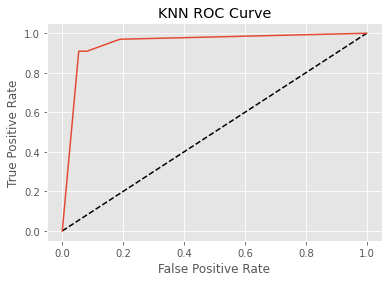

In [16]:
y_test_trans = (y_test=="republican") # republican = 1, democrat = 0
y_pred_prob_trans = y_pred_prob[:,1] # 預測是 republican 的 機率

auc = roc_auc_score(y_test_trans, y_pred_prob_trans)

print(f"auc: {auc}")

fpr, tpr, thresholds = roc_curve(y_test_trans, y_pred_prob_trans)
plt.plot([0,1],[0, 1], "k--")
plt.plot(fpr, tpr, label = "KNN (K = 5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC Curve")
plt.show()

#### 最完整流程整理

* 來講最完整的流程  
  * 分 train/test  
  * 定 pipeline 
    * 定義 preprocessing steps  
    * 定義 classifier. 
  * hyper-parameter tunning   
    * grid search  
    * random search  
  * 用整個 training set 做 fitting. 
  * 對 testing set 做 predict. 
  * 評估模型表現  
    * threshold. 
    * non-trheshold
  * 細節資訊探索(e.g. fitting後的參數,...)

##### 分 train/test

In [57]:
# 分 train/test
X = vote.drop("party", axis = 1)
y = vote["party"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.3, 
    random_state = 21, 
    stratify = y
)

##### 做 pipeline

* 對 knn 這種依賴 euclidean distance 的演算法，必須先做 normalization，再開始算距離，所以 pipeline寫成這樣：

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# preprocess
scaler = StandardScaler()

# model
knn = KNeighborsClassifier()

# pipeline
my_pipe = Pipeline([
    ("scaler", scaler),
    ("knn", knn)
])

##### 做 hyper-parameter tunning

* 先來做 grid_search

In [43]:
from sklearn.model_selection import GridSearchCV

parameters = {"knn__n_neighbors": np.arange(1, 50)}
grid_cv = GridSearchCV(my_pipe, 
                       param_grid = parameters, 
                       cv = 5,
                       scoring='roc_auc');
grid_cv.fit(X_train, y_train);

* 這邊看一下，第二列的 parameters 裡面，"knn__"的knn，是用我的 my_pipe 物件裡的名稱 ("knn"); "n_neighbors" 是超參數的名稱
* 做完 fitting 後的物件就是 grid_cv 了，我們可以看最佳參數是多少：

In [44]:
grid_cv.best_params_

{'knn__n_neighbors': 17}

* 可以知道，最佳參數是 17. 

In [45]:
?ref:scoring_parameter

Object `ref:scoring_parameter` not found.


In [46]:
?GridSearchCV

Init signature:
GridSearchCV(
    estimator,
    param_grid,
    *,
    scoring=None,
    n_jobs=None,
    refit=True,
    cv=None,
    verbose=0,
    pre_dispatch='2*n_jobs',
    error_score=nan,
    return_train_score=False,
)
Docstring:     
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a "fit" and a "score" method.
It also implements "score_samples", "predict", "predict_proba",
"decision_function", "transform" and "inverse_transform" if they are
implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized
by cross-validated grid-search over a parameter grid.

Read more in the :ref:`User Guide <grid_search>`.

Parameters
----------
estimator : estimator object
    This is assumed to implement the scikit-learn estimator interface.
    Either estimator needs to provide a ``score`` function,
    or ``scoring`` must be passed.

param_grid : dict or list of

In [47]:
grid_cv.cv_results_

{'mean_fit_time': array([0.00410557, 0.00349936, 0.00289578, 0.00251188, 0.00247269,
        0.00252709, 0.00272069, 0.00246129, 0.00306287, 0.00371184,
        0.00294638, 0.00308042, 0.00299649, 0.00300522, 0.00273948,
        0.00361261, 0.00310259, 0.00313864, 0.00295277, 0.00384784,
        0.00304828, 0.00281844, 0.00319686, 0.00302219, 0.00305853,
        0.00290966, 0.00289521, 0.00281544, 0.00308471, 0.00267277,
        0.00285001, 0.0030632 , 0.00333405, 0.00302234, 0.00311818,
        0.00305524, 0.00284081, 0.00307274, 0.00295916, 0.00310979,
        0.00310645, 0.00305629, 0.00277839, 0.00244412, 0.00253983,
        0.00268669, 0.00238819, 0.00241308, 0.00232444]),
 'std_fit_time': array([7.88619106e-04, 9.42372814e-04, 5.09592826e-04, 2.05940145e-04,
        1.30329147e-04, 1.39555875e-04, 4.71658495e-04, 9.38250994e-05,
        7.01362537e-04, 9.40648512e-04, 5.46725004e-04, 6.70972481e-04,
        6.49284812e-04, 6.08038812e-04, 4.14937119e-04, 5.44774122e-04,
        4

##### 用整個 training set 做 fitting. 

* 剛剛的 grid_cv 物件，再找完最佳參數後，就已經幫你把整個 training set 給 fit 完了

##### 用 testing set 做 predict

In [49]:
pred_label_test = grid_cv.predict(X_test)
pred_prob_test = grid_cv.predict_proba(X_test)

##### 效果評估

In [51]:
# 評估結果
print(grid_cv.score(X_test, y_test))
print(confusion_matrix(y_test, pred_label_test))
print(classification_report(y_test, pred_label_test))

0.9426699426699426
[[31  6]
 [ 3 30]]
              precision    recall  f1-score   support

    democrat       0.91      0.84      0.87        37
  republican       0.83      0.91      0.87        33

    accuracy                           0.87        70
   macro avg       0.87      0.87      0.87        70
weighted avg       0.87      0.87      0.87        70



### KNN (multi_class)

#### 讀資料集

* 要來引入數字辨認資料集

In [27]:
from sklearn import datasets
digits = datasets.load_digits()

* 這筆資料，x 分成兩種：  
  * images: 1797張image x 8 x 8 的 3d-array. 
  * data: 每張 image 拉成 64 個 column，所以變成 1797x64 的 2d-array
* 看一下 shape 是不是真的是這樣：

In [28]:
print(digits.images.shape)
print(digits.data.shape)

(1797, 8, 8)
(1797, 64)


* 我們可以看一張圖片：

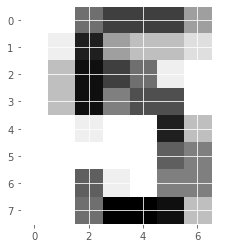

In [29]:
plt.imshow(digits.images[1010], cmap=plt.cm.gray_r, interpolation='nearest');

* 那這個任務，蠻熟悉的，就是給我一張圖片，然後我要辨認出他是 0 ~ 9 的哪個數字

#### fit model & predict

In [30]:
# 切資料
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, 
    digits.target, 
    test_size = 0.2, 
    random_state = 42, 
    stratify = digits.target
)

# fit model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(X_train, y_train)

# 預測 training/testing set
pred_label_train = knn.predict(X_train)
pred_prob_train = knn.predict_proba(X_train)

pred_label_test = knn.predict(X_test)
pred_prob_test = knn.predict_proba(X_test)

# 評估結果
print(knn.score(X_test, y_test))
print(confusion_matrix(y_test, pred_label_test))
print(classification_report(y_test, pred_label_test))

0.9805555555555555
[[36  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  1  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  3  0  0  0  0  0  1 31  0]
 [ 0  0  0  0  1  0  0  0  1 34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.92      1.00      0.96        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       0.97      1.00      0.99        36
           8       0.94      0.89      0.91        35
           9       1.00      0.94      0.97        36

    accuracy                           0.98       360


#### overfitting exploration

* 最後，我們來玩點新的，看看 overfitting 的狀況

In [31]:
neighbors = np.arange(1, 9) # knn的 k，從複雜(1)到簡單(9)
train_accuracy = np.empty(len(neighbors)) # 先擺個 placeholder
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

* 畫個圖看看

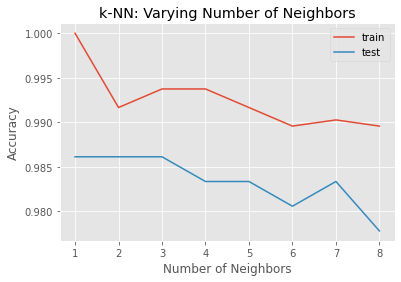

In [32]:
fig, ax = plt.subplots()
ax.plot(neighbors, train_accuracy, label = "train");
ax.plot(neighbors, test_accuracy, label = "test");
ax.legend();
ax.set(
    xlabel='Number of Neighbors', 
    ylabel='Accuracy',
    title='k-NN: Varying Number of Neighbors'
);

### Logistic (binary)

#### 讀資料集

In [52]:
diabetes = pd.read_csv("data/diabetes.csv")
diabetes

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [54]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pregnancies  768 non-null    int64  
 1   glucose      768 non-null    int64  
 2   diastolic    768 non-null    int64  
 3   triceps      768 non-null    int64  
 4   insulin      768 non-null    int64  
 5   bmi          768 non-null    float64
 6   dpf          768 non-null    float64
 7   age          768 non-null    int64  
 8   diabetes     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### fit, predict, and evaluate

/Volumes/GoogleDrive/我的雲端硬碟/0. codepool_python/python_ds/python_ds_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Volumes/GoogleDrive/我的雲端硬碟/0. codepool_python/python_ds/python_ds_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alterna

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'penalty': 'l2'}
Best score is 0.7891304347826086
[[169  32]
 [ 47  60]]
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       201
           1       0.65      0.56      0.60       107

    accuracy                           0.74       308
   macro avg       0.72      0.70      0.71       308
weighted avg       0.74      0.74      0.74       308



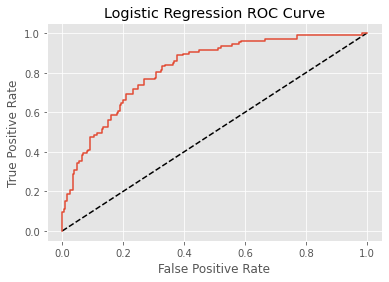

0.7007718417259498


In [55]:
# 切資料
from sklearn.model_selection import train_test_split

# preprocess (沒用到)
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline

# modeling
from sklearn.linear_model import LogisticRegression

# hyper-parameter tunning
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score


# 切資料
X = diabetes.drop("diabetes", axis = 1)
y = diabetes["diabetes"]
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.4, 
    random_state = 42, 
    stratify = y
)

# model
logreg = LogisticRegression()

# hyper-parameter tunning
# logistic regression 的 regularization parameter 是 C ，代表 inverse of the regularization strength, 
# 所以，C 越大，regularize能力越爛，越容易 overfit model; 
# C 越小，regularize能力越強，越容易 underfit model
c_space = np.logspace(-5, 8, 15)
param_grid = {"C": c_space, "penalty": ['l1', 'l2']}
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X_train, y_train)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# 預測 training/testing set
y_pred = logreg_cv.predict(X_test)
y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]


# 評估結果
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0, 1], "k--")
plt.plot(fpr, tpr, label = "Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.show()

print(roc_auc_score(y_test, y_pred))

* precision & recall
  * precision = 你說是 positive 的人中，有多少個是真的 positive
  * recall = true positive rate = 真的是positive的人中，你揪出了幾個？
  * cutpoint -> 1, precision ->1，因為惜字如金，只要我說是positive，幾乎一定是 positive。
  * cutpoint -> 0, recall -> 1, 因為cutpoint接近0的時候，幾乎所有人全被說 positive，那recall的分子就幾乎全中了

### DecisionTree (binary)

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 5}
Best score is 0.7608695652173914
AUC: 0.7851629701957501
[[174  27]
 [ 57  50]]
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       201
           1       0.65      0.47      0.54       107

    accuracy                           0.73       308
   macro avg       0.70      0.67      0.67       308
weighted avg       0.72      0.73      0.71       308



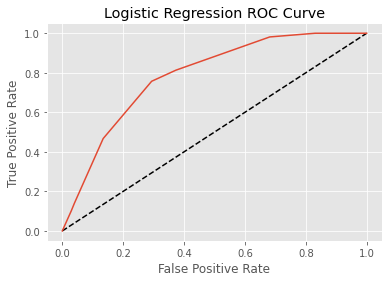

In [62]:
# 切資料
from sklearn.model_selection import train_test_split

# preprocess (沒用到)
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline

# modeling
from sklearn.tree import DecisionTreeClassifier

# hyper-parameter tunning
from sklearn.model_selection import RandomizedSearchCV

# evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# utils  
from scipy.stats import randint



# 讀檔 & 切資料
diabetes = pd.read_csv("data/diabetes.csv")
X = diabetes.drop("diabetes", axis = 1)
y = diabetes["diabetes"]
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.4, 
    random_state = 42, 
    stratify = y
)

# model
tree = DecisionTreeClassifier()

# hyper-parameter tunning
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
tree_randomcv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_randomcv.fit(X_train, y_train)
print("Tuned Decision Tree Parameters: {}".format(tree_randomcv.best_params_))
print("Best score is {}".format(tree_randomcv.best_score_))

# 預測 training/testing set
y_pred = tree_randomcv.predict(X_test)
y_pred_prob = tree_randomcv.predict_proba(X_test)[:,1]


# 評估結果
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0, 1], "k--")
plt.plot(fpr, tpr, label = "Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.show()

### SVC (binary)

In [74]:
# Import necessary modules
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# 讀資料
vote_raw = pd.read_csv("data/house-votes-84.csv")
vote = vote_raw.copy()
col_names = ['party', 'infants', 'water', 'budget', 'physician', 'salvador',
       'religious', 'satellite', 'aid', 'missile', 'immigration', 'synfuels',
       'education', 'superfund', 'crime', 'duty_free_exports', 'eaa_rsa']
vote.columns = col_names
vote[vote == "?"] = np.nan # 把 ? 改成 na
for i in col_names[1:]:
    vote[i] = vote[i].replace({"y": 1, "n": 0})
X = vote.drop("party", axis = 1)
y = vote["party"]

# 切資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# pipeline: 前處理 & model
steps = [('imputation', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ("scaler", StandardScaler()),
        ('SVM', SVC())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)


# hyper-parameter tunning
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}
cv = GridSearchCV(pipeline, parameters, cv = 3)
cv.fit(X_train, y_train)
print("Tuned Model Parameters: {}".format(cv.best_params_))

# 預測
y_pred = cv.predict(X_test)

# performance
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.01}
Accuracy: 0.9541984732824428
              precision    recall  f1-score   support

    democrat       0.99      0.94      0.96        83
  republican       0.90      0.98      0.94        48

    accuracy                           0.95       131
   macro avg       0.95      0.96      0.95       131
weighted avg       0.96      0.95      0.95       131



## Regression

### Gapminder Data

In [63]:
import pandas as pd
gapminder = pd.read_csv("data/gm_2008_region.csv")
gapminder.head()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5,Middle East & North Africa
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0,Sub-Saharan Africa
2,40381860.0,2.24,0.5,4.785170,27.50170,14646.0,118.8915,75.5,15.4,America
3,2975029.0,1.40,0.1,1.804106,25.35542,7383.0,132.8108,72.5,20.0,Europe & Central Asia
4,21370348.0,1.96,0.1,18.016313,27.56373,41312.0,117.3755,81.5,5.2,East Asia & Pacific


In [64]:
gapminder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   population       139 non-null    float64
 1   fertility        139 non-null    float64
 2   HIV              139 non-null    float64
 3   CO2              139 non-null    float64
 4   BMI_male         139 non-null    float64
 5   GDP              139 non-null    float64
 6   BMI_female       139 non-null    float64
 7   life             139 non-null    float64
 8   child_mortality  139 non-null    float64
 9   Region           139 non-null    object 
dtypes: float64(9), object(1)
memory usage: 11.0+ KB


### Linear Regression

#### train/test

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# preprocess. 
# gapminder_onehot = pd.get_dummies(gapminder)
gapminder_dummy = pd.get_dummies(gapminder, drop_first = True)

# 分割資料
X = gapminder_dummy.drop("life", axis = 1)
y = gapminder_dummy["life"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# fit model
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.8219419939587727
Root Mean Squared Error: 3.405248115733344


#### CV

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# 分割資料
# 不分割了，因為等等直接用 cv

# fit model
reg = LinearRegression()
cv_scores = cross_val_score(reg, X, y, cv = 5)

print(cv_scores) # 5-fold cv 結果

print(f"Average 5-Fold CV Score: {str(np.mean(cv_scores))}")

[0.8196741  0.80301541 0.89758712 0.80425614 0.94015848]
Average 5-Fold CV Score: 0.8529382494240787


### Lasso Regression

In [67]:
# Import Lasso
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# pipeline
lasso_pipe = make_pipeline(
    StandardScaler(),
    Lasso(alpha = 0.4)
)

# Fit the regressor to the data
lasso_pipe.fit(X_train, y_train)

y_pred = lasso_pipe.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(lasso_pipe.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.8401265152705228
Root Mean Squared Error: 3.2266824659707334


* 看一下哪些變數被 shrinkage 到 0 ，哪些變數最重要：

[-0.         -0.08591553 -2.91968634 -0.          0.58693244  1.6922106
 -1.11083667 -4.3362549  -0.48746711  0.          0.          0.
 -0.1705074 ]


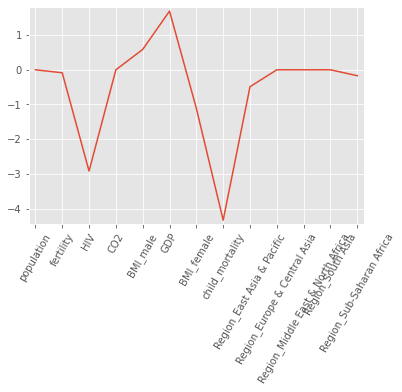

In [68]:
# Compute and print the coefficients
lasso_coef = lasso_pipe.named_steps["lasso"].coef_
print(lasso_coef)

# Plot the coefficients

plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=60)
plt.margins(0.02)

### Ridge Regression

In [69]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

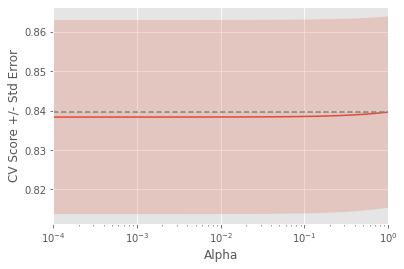

In [70]:
# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    
    ridge = make_pipeline(
        StandardScaler(),
        Ridge(alpha = alpha)
    )
    # ridge.named_steps["ridge"].alpha = alpha
    #ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

### Elastic net

In [75]:
# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

# 讀資料 & 切資料
gapminder = pd.read_csv("data/gm_2008_region.csv")
X = gapminder_dummy.drop("life", axis = 1)
y = gapminder_dummy["life"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

# pipeline: 前處理 & model
steps = [('imputation', SimpleImputer(missing_values=np.nan, strategy='mean')),
         ("scaler", StandardScaler()),
         ("elasticnet", ElasticNet())]
pipeline = Pipeline(steps)

# hyper-parameter tunning
parameters = {"elasticnet__l1_ratio":np.linspace(0,1,30)} # l1_ratio*L1_loss + (1-l1_ratio)*L2_loss
gm_cv = GridSearchCV(pipeline, parameters, cv = 5)
gm_cv.fit(X_train, y_train)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))

# Predict
y_pred = gm_cv.predict(X_test)

# performance
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

/Volumes/GoogleDrive/我的雲端硬碟/0. codepool_python/python_ds/python_ds_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.126e+02, tolerance: 5.589e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Volumes/GoogleDrive/我的雲端硬碟/0. codepool_python/python_ds/python_ds_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.410e+02, tolerance: 5.893e-01 Linear regression models with null weight 

Tuned ElasticNet l1 ratio: {'elasticnet__l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.8862016549771035
Tuned ElasticNet MSE: 8.594868215979249
